# Reversed MC RAPTOR

## Left out at this stage:

- Footpaths
- Time to get out of one transport and walk to the platform of the next
- Real probabilities

## Encoding the data structures
### General considerations
We adhere to the data structures proposed by Delling et al. These structures aim to minimize read times in memory by making use of consecutive in-memory adresses. Thus, structures with varying dimensions (e.g dataframes, python lists) are excluded. We illustrate the difficulty with an example. 

Each route has a potentially unique number of stops. Therefore, we cannot store stops in a 2D array of routes by stops, as the number of stops is not the same for each route. We adress this problem by storing stops consecutively by route, and keeping track of the index of the first stop for each route.

This general strategy is applied to all the required data structures, where possible.

### routes
The `routes` array will contain arrays `[n_trips, n_stops, pt_1st_stop, pt_1st_trip]` where all four values are `int`. To avoid overcomplicating things and try to mimic pointers in python, `pt_1st_stop` and `pt_1st_trip` contain integer indices.

In [10]:
import numpy as np
import pickle

def pkload(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [19]:
routes = pkload("../data/routes_array.pkl")[:, [0,1,3,2]] # Fixing the order -> remove the indexation once the pkl file is fixed
routes[:,[3,2]] = np.concatenate(([[0,0]], routes[:-1,[3,2]]), axis=0)
routes

array([[140, 3, 0, 0],
       [37, 4, 3, 140],
       [48, 5, 7, 177],
       ...,
       [84, 2, 3273, 22625],
       [85, 2, 3275, 22709],
       [13, 5, 3277, 22794]], dtype=object)

In [1]:
# routes = np.array([[2, 3, 0, 0], #r0
#                    [2, 3, 3, 6], #r1
#                   [2, 2, 6, 12]]) # r2

### routeStops
`routeStops` is an array that contains the ordered lists of stops for each route. `pt_1st_stop` in `routes` is required to get to the first stop of the route. is itself an array that contains the sequence of stops for route $r_i$.

In [17]:
routeStops = pkload("../data/route_stops_array.pkl")
routeStops

array([ 791, 1036, 1037, ...,  471,  472,  473])

In [2]:
# routeStops = np.array([0, 1, 2, # A, B, C
#                        3, 2, 4, # D, C, E
#                       0, 4]) # A, E

### stopTimes

The i-th entry in the `stopTimes` array is itself an array which contains the arrival and departure time at a particular stop for a particular trip. `stopTimes` is sorted by routes, and then by trips. We retrieve the index of the first (earliest) trip of the route with the pointer `pt_1st_trip` stored in `routes`. We may use the built-in `numpy` [date and time data structures](https://blog.finxter.com/how-to-work-with-dates-and-times-in-python/). In short, declaring dates and times is done like this: `np.datetime64('YYYY-MM-DDThh:mm')`. Entries with a `NaT` arrival or departure times correspond to beginning and end of trips respectively.

Note that trips are indexed implicitely in stopTimes, but we decided to change a little bit from the paper and index them according to their parent route instead of giving them an absolute index. It makes things a bit easier when coding the algorithm.

In [20]:
stopTimes = pkload("../data/stop_times_array.pkl")
stopTimes

array([[                          'NaT', '2020-05-19T08:49:00.000000000'],
       ['2020-05-19T08:50:00.000000000', '2020-05-19T08:50:00.000000000'],
       ['2020-05-19T08:51:00.000000000', '2020-05-19T08:51:00.000000000'],
       ...,
       [                          'NaT', '2020-05-19T16:07:00.000000000'],
       ['2020-05-19T16:11:00.000000000', '2020-05-19T16:15:00.000000000'],
       ['2020-05-19T16:19:00.000000000',                           'NaT']],
      dtype='datetime64[ns]')

In [3]:
# stopTimes = np.array([
#     # r0, t0
#     [None, '2020-05-11T08:00'],
#     ['2020-05-11T08:25', '2020-05-11T08:30'],
#     ['2020-05-11T08:55', None],

#     # ro, t1
#     [None, '2020-05-11T08:10'],
#     ['2020-05-11T08:35', '2020-05-11T08:40'],
#     ['2020-05-11T09:05', None],
    
#     # r1, t0 
#     [None, '2020-05-11T08:00'],
#     ['2020-05-11T08:05', '2020-05-11T08:10'],
#     ['2020-05-11T08:15', None],

#     # r1, t1
#     [None, '2020-05-11T09:00'],
#     ['2020-05-11T09:05', '2020-05-11T09:10'],
#     ['2020-05-11T09:15', None],
    
#     #r2, t0
#     [None, '2020-05-11T08:20'],
#     ['2020-05-11T09:20', None],
    
#     #r2, t1
#     [None, '2020-05-11T08:30'],
#     ['2020-05-11T09:30', None]],
#     dtype='datetime64')

`NaT` is the `None` equivalent for `numpy datetime64`.

In [21]:
np.isnat(stopTimes[0])

array([ True, False])

### stopRoutes

`stopRoutes` contains the routes associated with each stop. We need the pointer in `stops` to index `stopRoutes` correctly.

In [24]:
stopRoutes = pkload("../data/stop_routes_array.pkl").flatten()
stopRoutes

array([1460288880641,  180388626432,  481036337153, ...,  317827579907,
        317827579906,  618475290627])

In [5]:
# stopRoutes = np.array([0, 2, # A
#                        0, # B
#                        0,1, # C
#                        1, # D
#                        1, 2]) # E

We should also build an array for transfer times (including walking times), but for now let's ignore this additional complexity. Finally, the i-th entry in the `stops` array points to the first entry in `stopRoutes` (and `transfers` when that will be tried) associated with stop $p_i$

In [25]:
stops = pkload("../data/stops_array.pkl")
stops

array([[1, 2],
       [2, 9],
       [3, 16],
       ...,
       [5387, 10654],
       [5389, 10669],
       [5398, 10702]], dtype=object)

In [30]:
print(stopRoutes.shape)
stops.shape

(5545,)


(1512, 2)

In [6]:
# # stopRoutes[stops[p][0]:stops[p][1]] returns the routes serving stop p.
# stops = np.array([[0,2],              # A
#                   [2,3],              # B
#                   [3,5],              # C
#                   [5,6],              # D
#                   [6,len(stopRoutes)] # E
#                  ])

## Coding the reversed Multiple Criteria RAPTOR

Based on modified version of RAPTOR (reversed RAPTOR), we implement a multiple criteria RAPTOR algorithm.
The optimization criteria are:
- Latest departure
- Highest probability of success of the entire trip
- Lowest number of connections (implicit with the round-based approach)

In [7]:
# helper functions

def arr_and_dep_time(r, t, offset_p):
    """This function should not be called directly.
    Use arrival_time and departure_time.
    In particular, this function relies on "t is not None"-
    """
    return stopTimes[routes[r][3]       # 1st trip of route
                     + t * routes[r][1] # offset for the right trip
                     + offset_p         # offset for the right stop
                    ]

def arrival_time(r, t, offset_p):
    """Returns 2000 (instead of 0) if t is None.
    Otherwise, returns the arrival time of the t-th trip of route r
    at the offset_p-th stop of route r.
    trips and stops of route r start at t=0, offset_p=0.
    """
    if t is None:
        return np.datetime64('2000-01-01T01:00')
    
    return arr_and_dep_time(r,t,offset_p)[0] # 0 for arrival time

def departure_time(r, t, offset_p):
    """Throws TypeError if t is None.
    Otherwise, returns the departure time of the t-th trip of route r
    at the offset_p-th stop of route r.
    trips and stops of route r start at t=0 & offset_p=0.
    """
    if t is None:
        raise TypeError("Requested departure time of None trip!")
    
    return arr_and_dep_time(r,t,offset_p)[1] # 1 for departure time

def get_stops(r):
    """Returns the stops of route r"""
    idx_first_stop = routes[r][2]
    return routeStops[idx_first_stop:idx_first_stop+routes[r][1]] # n_stops = routes[r][1]    

In [23]:
class InstantiationException(Exception):
    pass

class BaseLabel:
    """An abstract base class for Labels. Do not instantiate.
    A label corresponds to a recursive (partial) solution, going
    to the target stop from the stop currently under consideration.
    """
    def __init__(self, stop, tau_dep, Pr):
        self.stop    = stop
        self.tau_dep = tau_dep
        self.Pr      = Pr
    
    def dominates(self, other):
        """Returns True if self dominates other, else returns False.
        other: another Label instance.
        """
        if self.tau_dep >= other.tau_dep and self.Pr >= other.Pr:
            return True
        return False
    
    def print_journey(self):
        print("Journey begins at stop {stop} at time {tau}, with an "
              "overall probability of success = {Pr} \n".format(
                  stop = self.stop,
                  tau  = self.tau_dep,
                  Pr   = self.Pr
              )
             )
        self.print_instructions()
    
    def to_str(self):
        s = "Departure at {0} from stop {1}.".format(self.tau_dep, self.stop)
        return repr(type(self)) + s
    
    def pprint(self, indent=''):
        print(indent, self.to_str())
    
    def copy(self):
        raise InstantiationException("class BaseLabel should never "
                                     "be instantiated."
                                    )

class ImmutableLabel(BaseLabel):
    """Base class for immutable Labels"""
    def copy(self):
        return self

class TargetLabel(ImmutableLabel):
    """A special type of label reserved for the target stop."""
    def __init__(self, stop, tau_dep):
        BaseLabel.__init__(self, stop, tau_dep, 1.)
        
    def print_instructions(self):
        """Finish printing instructions for the journey."""
        print("You have arrived at the target stop ({stop}) "
              "before the target time of {tau}.".format(
                  stop=self.stop,
                  tau=self.tau_dep
              ))

class WalkLabel(ImmutableLabel):
    """A special type of label for walking connections."""
    def __init__(self, stop, tau_walk, next_label):
        tau_dep = next_label.tau_dep - tau_walk
        BaseLabel.__init__(self, stop, tau_dep, next_label.Pr)
        self.tau_walk   = tau_walk
        self.next_label = next_label
        
    def print_instructions(self):
        """Recursively print instructions for the whole journey."""
        print("Walk {tau} minutes from stop {p1} to stop {p2}"
              ".".format(
            tau = self.tau_walk,
            p1  = self.stop,
            p2  = self.next_label.stop
        ))
        self.next_label.print_instructions()

class RouteLabel(BaseLabel):
    """A type of label for regular transports."""
    def __init__(self,
                 stop,
                 tau_dep,
                 r,
                 t,
                 next_label,
                 Pr_connection_success):
        
        Pr = Pr_connection_success * next_label.Pr
        BaseLabel.__init__(self, stop, tau_dep, Pr)
        
        self.r           = r
        self.t           = t
        self.next_label  = next_label
        self.route_stops = get_stops(r)
        self.offset_p    = np.where(self.route_stops == stop)[0][0]
        # Store Pr_connection_success for self.copy()
        self.Pr_connection_success = Pr_connection_success
    
    def update_stop(self, stop):
        self.stop     = stop
        self.offset_p = self.offset_p - 1
        # Sanity check:
        assert self.route_stops[self.offset_p] == stop
        self.tau_dep  = departure_time(self.r, self.t, self.offset_p)
        
    def print_instructions(self):
        """Recursively print instructions for the whole journey."""
        print(" "*4 + "At stop {stop}, take route {r} at time "
              "{tau}.".format(stop=self.stop,
                              r=self.r,
                              tau=self.tau_dep
                             )
             )
        tau_arr = arrival_time(
                    self.r,
                    self.t,
                    np.where(self.route_stops == self.next_label.stop)
                    )
        print(" "*4 + "Get out at stop {stop} at time {tau}"
              ".".format(stop=self.next_label.stop, tau=tau_arr)
             )
        self.next_label.print_instructions()
        
    def copy(self):
        """When RouteLabels are merged into the bag of a stop,
        they must be copied (because they will subsequently
        be changed with self.update_stop()).
        """
        return RouteLabel(self.stop,
                          self.tau_dep,
                          self.r,
                          self.t,
                          self.next_label,
                          self.Pr_connection_success
                         )

In [34]:
p_s = 0 # start stop = A
p_t = 4 # target stop = E
tau_0 = np.datetime64('2020-05-11T09:30') # arrival time 09:30
Pr_min = 0.9
Pr_threshold = Pr_min**(0.1)

In [35]:
# initialization
n_stops = stops.shape[0]

# Initialize empty bags for each stop for round 0:
bags = [
    [
        [] # an empty bag
    for _ in range(n_stops)] # one empty bag per stop
]

marked = [p_t]
bags[0][p_t].append(TargetLabel(p_t, tau_0))
bags

[[[], [], [], [], [<__main__.TargetLabel at 0x7f2e69e0e090>]]]

In [36]:
# bag operations
def update_bag(bag, label, k):
    """Add label to bag and remove dominated labels.
    bag is altered in-place.
    
    k: Round number, used for target pruning.
    
    returns: Boolean indicating whether bag was altered.
    """
    # Apply the Pr_min constraint to label:
    if label.Pr < Pr_min:
        return False
    
    # Prune label if it is dominated by bags[k][p_s]:
    for L_star in bags[k][p_s]:
        if L_star.dominates(label):
            return False
    
    # Otherwise, merge label into bag1
    changed = False
    for L_old in bag:
        if L_old.dominates(label):
            return changed
        if label.dominates(L_old):
            bag.remove(L_old)
            changed = True
    bag.append(label.copy())
    return True

def merge_bags(bag1, bag2, k):
    """Merge bag2 into bag1 in-place.
    k: Round number, used for target pruning.
    returns: Boolean indicating whether bag was altered.
    """
    changed = False
    for label in bag2:
        changed = changed or update_bag(bag1, label, k)
    return changed

In [37]:
# main loop
indent= ' '*4

k = 0
while True:
    k += 1 # k=1 at fist round, as it should.
    
    # Instead of using best bags, carry over the bags from last round.
#     if len(bags <= k):
    
    bags.append(bags[-1].copy())
    
    print('\n******************************STARTING round k={}******************************'.format(k))
    # accumulate routes serving marked stops from previous rounds
    q = []
    print('Marked stops at the start of the round: {}'.format(marked))
    for p in marked:
        for r in stopRoutes[stops[p][0]:stops[p][1]]: # foreach route r serving p
            append_r_p = True
            for idx, (rPrime, pPrime) in enumerate(q): # is there already a stop from the same route in q ?
                if rPrime == r:
                    append_r_p = False
                    p_pos_in_r = np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p)
                    pPrime_pos_in_r = np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == pPrime)
                    if p_pos_in_r > pPrime_pos_in_r:
                        q[idx] = (r, p) # substituting (rPrime, pPrime) by (r, p)
            if append_r_p:
                q.append((r, p))
                
    marked = [] # unmarking all stops
    
    print('Queue before traversing each route: {}'.format(q))
    # traverse each route
    for (r, p) in q:
        print('\n****TRAVERSING ROUTE r={0} from stop p={1}****'.format(r, p))
        B_route = [] # new empty route bag
        
        # we traverse the route backwards (starting at p, not from the end of the route)
        stops_of_current_route = get_stops(r)
        offset_p = np.where(stops_of_current_route == p)[0][0]
        for offset_p_i in range(offset_p, -1, -1):
            p_i = stops_of_current_route[offset_p_i]
            print('\n\n'+indent+"p_i: {}".format(p_i))
            
            # Update the labels of the route bag:
            for L in B_route:
                L.update_stop(p_i)
            
            # Merge B_route into bags[k][p_i]
            if merge_bags(bags[k][p_i], B_route, k):
                marked.append(p_i)
            
            # Can we step out of a later trip at p_i ?
            # This is only possible if we already know a way to get from p_i to p_t in < k vehicles
            # (i.e., if there is at least one label in bags[k][p_i])
            for L_k in bags[k][p_i]:
                # Note that k starts at 1 and bags[0][p_t] contains a TargetLabel.
                print('\n'+indent+'----scanning arrival times for route r={0} at stop p_i={1}----'.format(r, p_i))
                
                # We check the trips from latest to earliest
                for t in range(routes[r][0]-1, -1, -1): # n_trips = routes[r][0]
                    # Does t_r arrive early enough for us to make the rest 
                    # of the journey from here (tau[k-1][p_i])?
                    if arrival_time(r, t, offset_p_i) <= L_k.tau_dep:
                        
                        Pr_connection = t / (routes[r][0]-1) # This is a placeholder.
                        L_new = RouteLabel(p_i,
                                           departure_time(r, t, offset_p_i),
                                           r,
                                           t,
                                           L_k,
                                           Pr_connection
                                          )
                        if update_bag(B_route, L_new, k):
                            print(indent+"Explored connection from")
                            L_new.pprint(indent*2)
                            print(indent+"to")
                            L_k.pprint(indent*2)
                        
                        # We don't want to add a label for every trip that's earlier than tau_dep.
                        # Instead, we stop once we've found a trip that's safe enough.
                        if Pr_connection > Pr_threshold:
                            break
                        
    # stopping criteria
    if not marked:
        print("\n" + "*"*15 + " THE END " + "*"*15)
        print("Equilibrium reached. The end.")
        break
    if k>2:
        if bags[k-1][p_s]:
            print("\n" + "*"*15 + " THE END " + "*"*15)
            print("There is a solution with {0} connections. We shall not "
                  "search for solutions with {1} or more connections"
                  ".".format(k-2, k)
                 )
            break


******************************STARTING round k=1******************************
Marked stops at the start of the round: [4]
Queue before traversing each route: [(1, 4), (2, 4)]

****TRAVERSING ROUTE r=1 from stop p=4****


    p_i: 4

    ----scanning arrival times for route r=1 at stop p_i=4----
    Explored connection from
         <class '__main__.RouteLabel'>Departure at NaT from stop 4.
    to
         <class '__main__.TargetLabel'>Departure at 2020-05-11T09:30 from stop 4.


    p_i: 2

    ----scanning arrival times for route r=1 at stop p_i=2----


    p_i: 3

    ----scanning arrival times for route r=1 at stop p_i=3----

****TRAVERSING ROUTE r=2 from stop p=4****


    p_i: 4

    ----scanning arrival times for route r=2 at stop p_i=4----
    Explored connection from
         <class '__main__.RouteLabel'>Departure at NaT from stop 4.
    to
         <class '__main__.TargetLabel'>Departure at 2020-05-11T09:30 from stop 4.


    p_i: 0

    ----scanning arrival times for route 

In [38]:
for i, label in enumerate(bags[k][p_s]):
    print('\n'*2,'-'*10, 'OPTION', i)
    label.print_journey()



 ---------- OPTION 0
Journey begins at stop 0 at time 2020-05-11T08:30, with an overall probability of success = 1.0 

    At stop 0, take route 2 at time 2020-05-11T08:30.
    Get out at stop 4 at time [['2020-05-11T09:30'              'NaT']].
You have arrived at the target stop (4) before the target time of 2020-05-11T09:30.


## Code for prototyping and debugging:

(array([99., 80., 47., 22., 15., 11.,  3.,  0.,  1.,  1.]),
 array([1.0, 6.9, 12.8, 18.700000000000003, 24.6, 30.5, 36.400000000000006,
        42.300000000000004, 48.2, 54.1, 60.0], dtype=object),
 <a list of 10 Patch objects>)

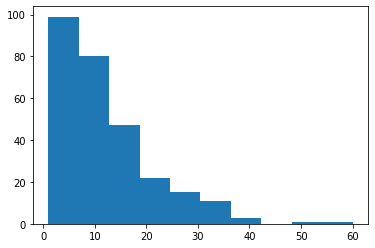

In [14]:
import matplotlib.pyplot as plt
# Plot distribution of n_stops
plt.hist(routes[:,1])

In [95]:
list(range(0,-1,-1))

[0]

In [49]:
l = list(range(6))
ret = l.remove(2)
print(ret)
l

None


[0, 1, 3, 4, 5]

In [14]:
B = [RouteLabel(1,1,0,0,TargetLabel(p_t, tau_0),0.8), RouteLabel(1,1,0,1,TargetLabel(p_t, tau_0),1)]
B[0].update_stop(0)
B[1].update_stop(0)
for l in B:
    l.pprint()

<class '__main__.RouteLabel'> Departure at 2020-05-11T08:00 from stop 0.
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:10 from stop 0.


In [15]:
label = RouteLabel(4,0, 2, 0, TargetLabel(p_t, tau_0), 0.9)
label.update_stop(0)
label.pprint()
print(update_bag(B, label, 0))
label.stop = 555
for l in B:
    l.pprint()
print('-'*10)
label.pprint()

<class '__main__.RouteLabel'> Departure at 2020-05-11T08:20 from stop 0.
True
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:10 from stop 0.
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:20 from stop 555.
----------
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:20 from stop 555.


In [27]:
bags = [[1,2,3]]
bags.append(bags[-1].copy())
bags[1][2] = 666
bags

[[1, 2, 3], [1, 2, 666]]

In [ ]:
p_s = 0 # start stop = A
p_t = 4 # target stop = E
tau_0 = np.datetime64('2020-05-11T08:05') # departure time 08:05
k_max = 10 # we set a maximum number of transports to pre-allocate memory for the numpy array tau_i

In [ ]:
# initialization
n_stops = len(stops)

# earliest arrival time at each stop for each round.
tau = np.full(shape=(k_max, n_stops), fill_value = np.datetime64('2100-01-01T00:00')) # 2100 instead of infinity # number of stops * max number of transports

# earliest arrival time at each stop, indep. of round
tau_star = np.full(shape=n_stops, fill_value = np.datetime64('2100-01-01T00:00'))

marked = [p_s]
q = []
tau[0, p_s] = tau_0

In [ ]:
np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0]

In [ ]:
routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i

In [ ]:
p_i

In [ ]:
t_r_dep = stopTimes[routes[r][3]+\
                     # offset corresponding to stop p_i in route r
                     np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0] + \
                     routes[r][1]*t_r][1]

In [ ]:
if np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2) <\
np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 3):
    print("hello")

In [ ]:
routeStops[routes[1][2] + np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2)[0][0]:routes[1][2]+routes[1][1]]

In [ ]:
routeStops[routes[1][2] + np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2)[0][0]:6]

In [ ]:
routeStops[routes[1][2]]

In [ ]:
routeStops[np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2)[0][0]]

In [ ]:
if True and \
        True:
    print("hello")

In [ ]:
tau[0][0]

In [ ]:
stopTimes[3][1]

In [ ]:
a = np.arange(1, 10)
a

In [ ]:
a[1:10:2]

In [ ]:
stopTimes[routes[0][3]+\
          # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[0][2]:routes[0][2]+routes[0][1]] == 0)[0][0]:\
         # end of the trips of r
         routes[0][3]+routes[0][0]*routes[0][1]:\
          # we can jump from the number of stops in r to find the next departure of route r at p_i
         routes[0][1]
         ]
# we may more simply loop through all trips, and stop as soon as the departure time is after the arrival time


In [ ]:
stopTimes[routes[0][3]+\
          # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[0][2]:routes[0][2]+routes[0][1]] == 0)[0][0]][1]

In [ ]:
stopTimes[routes[1][3]+\
          # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 3)[0][0] + \
         routes[1][1]*1][1]

In [ ]:
# t_r is a trip that belongs to route r. t_r can take value 0 to routes[r][0]-1
t = None
r = 1
tau_k_1 = tau[0][0]
p_i = 3

t_r = 0
while True:
    
    t_r_dep = stopTimes[routes[r][3]+\
         # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0] + \
         routes[r][1]*t_r][1]
    
    if t_r_dep > tau_k_1:
        # retrieving the index of the departure time of the trip in stopTimes
        #t = routes[r][3] + t_r * routes[r][1]
        t = t_r
        break
    t_r += 1
    # we could not hop on any trip at this stop
    if t_r == routes[r][0]:
        break
        
print("done")
print(t)

In [ ]:
r = 1
t = 1
p_i = 2
# 1st trip of route + offset for the right trip + offset for the right stop
stopTimes[routes[r][3] + t * routes[r][1] + np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)]

In [ ]:
d = []
not d

In [ ]:
r = 1
t = 0
p_i = 4
arr_t_p_i = stopTimes[routes[r][3] + \
                          t * routes[r][1] + \
                          np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0]][0]
arr_t_p_i

In [ ]:
np.datetime64('NaT') > np.datetime64('2100-01-01')

In [ ]:
np.datetime64('NaT') < np.datetime64('2100-01-01')